# 4 - Different Methods for Inferring Velocities

In the [previous tutorial](https://eddy.readthedocs.io/en/latest/tutorials/tutorial_3.html), we saw how modeling the line center of an annulus of spectra as a simple harmonic oscillator provided a good way to extract radial profiles of $v_{\phi}$ and $v_{\rm r}$. While this was a quick approach, we essentially threw data away by collapsing each spectrum into a single value: the line center. In this tutorial, we will look at alternative methods to infer the velocity structure by leveraging as much information as possible.

## Background

To demonstrate the power of using a full spectrum in this endeavor, let's look at a [river plot](https://eddy.readthedocs.io/en/latest/tutorials/tutorial_3.html#Inspecting-an-Annulus) again. The figure below shows a river plot for an annulus between $1.5^{\prime\prime}$ to $1.6^{\prime\prime}$ in TW Hya. It cycles through different $v_{\phi}$ values, shown in the top left of the bottom panel.

<img src="./riverplot.gif">

As can be clearly seen, when $v_{\phi}$ approaches the correct value, the river straightens out and the azimuthally averaged spectrum, shown along the top, aproaches a high SNR Gaussian profile. There have been several approaches which have been described in the literature that leverage this fact. We'll explore them below.

## Deprojection Basics

First of all, we need to explore some of the features of the `annulus` class. Let's load up a cube and grab an annulus. Here we're using a slightly different example cube that has CS emission from [Teague et al. (2018b)](https://ui.adsabs.harvard.edu/abs/2018ApJ...864..133T/abstract) and is available for download from the `GoFish` [Dataverse](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/LO2QZM).

In [1]:
import os
if not os.path.exists('TWHya_CS_cube.fits'):
    !wget -O TWHya_CS_cube.fits -q https://dataverse.harvard.edu/api/access/datafile/:persistentId?persistentId=doi:10.7910/DVN/LO2QZM/KYZFUQ

In [2]:
import matplotlib.pyplot as plt
from eddy import linecube
import numpy as np

In [3]:
cube = linecube('TWHya_CS_cube.fits', FOV=8.0)

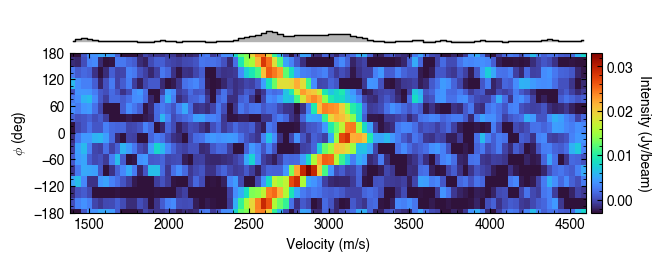

In [4]:
annulus = cube.get_annulus(r_min=1.5, r_max=1.6, inc=6.0, PA=151.0)
annulus.plot_river()

### Deprojected Spectrum

One of the fundamental functions of the `annulus` class is the `deprojected_spectrum` function. This shifts each spectrum by the projected velocity component decribed by $(v_{\rm \phi},\, v_{\rm r})$ and then averages of all spectra. This is what produces the spectrum on the top of the river plot.

In [5]:
x, y, dy = annulus.deprojected_spectrum(vrot=0.0)

(1417.3097826192488, 4567.690222234542)

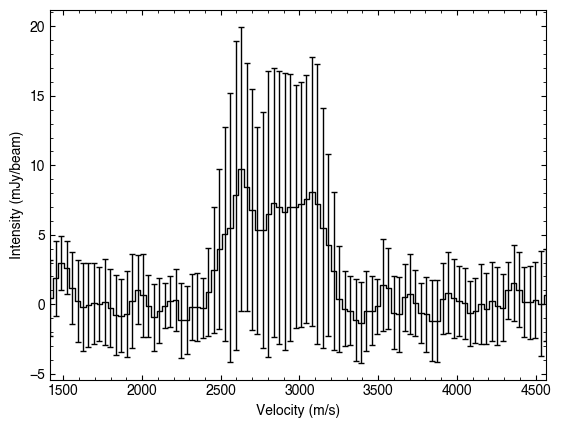

In [6]:
fig, ax = plt.subplots()
ax.errorbar(x, y * 1e3, dy * 1e3, fmt=' ', capsize=2.0, lw=1.0, color='k')
ax.step(x, y * 1e3, where='mid', lw=1.0, color='k')
ax.set_ylabel('Intensity (mJy/beam)')
ax.set_xlabel('Velocity (m/s)')
ax.set_xlim(x.min(), x.max())

The ``annulus`` class has a convenience function, ``plot_spectrum`` which will align, stack and plot the spectra for you!

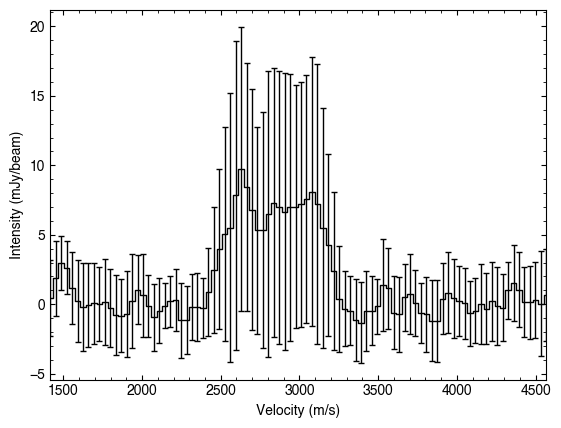

In [7]:
annulus.plot_spectrum(vrot=0.0)


Just as we did for the `plot_river` function, we can provide the correct rotation velocity to get a nicer looking spectrum. For now, let's use the `fit_SHO` approach to infer the velocity profile.

In [8]:
v, dv = annulus.get_vlos(fit_method='SHO')
v_phi, dv_phi = v[0], dv[0]
print('v_phi = {:.0f} +\- {:.0f} m/s'.format(v_phi, dv_phi))

v_phi = 2607 +\- 64 m/s


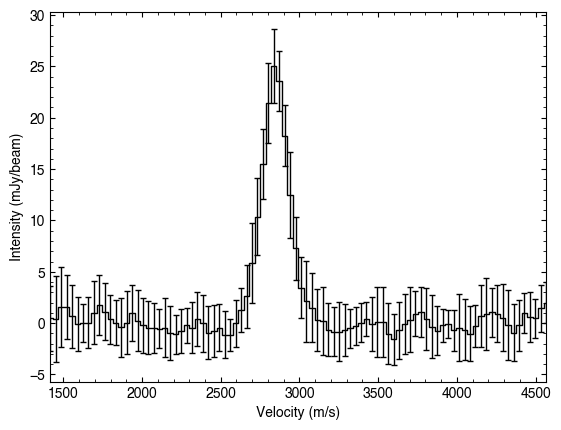

In [9]:
annulus.plot_spectrum(vrot=v_phi)

The `deprojected_spectrum` also takes a `vrad` argument in case you have an idea of what $v_{\rm r}$ should be. In addition, we can overplot a Gaussian fit to the data to check how well the aligning has done.

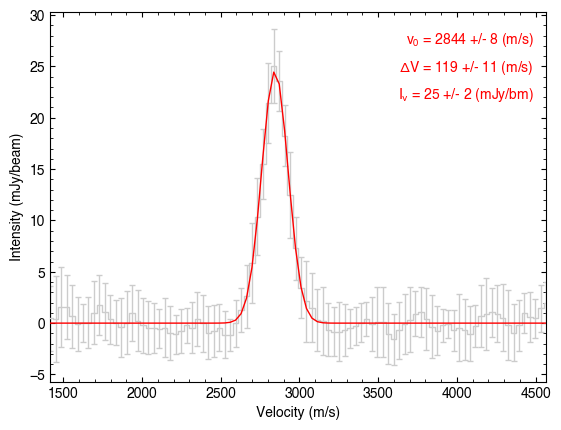

In [10]:
annulus.plot_spectrum(vrot=v_phi, plot_fit=True)

### Resampled Spectra

Another powerful aspect of the `deprojected_spectrum` function is that you can resample your averaged spectrum to a finer channel spacing, as done in [Teague & Loomis (2020)](https://ui.adsabs.harvard.edu/abs/2020ApJ...899..157T/abstract). This works because for each spectrum at a polar angle $\phi$, the Doppler shift is not quantized into channels meaning that we sample the underlying spectrum at a much higher rate. This can be seen when we use `resample=False`.

In [11]:
x, y, dy = annulus.deprojected_spectrum(vrot=v_phi, resample=False)

In [12]:
print('mean spacing = {:.1f} m/s'.format(np.diff(x).mean()))

mean spacing = 2.5 m/s


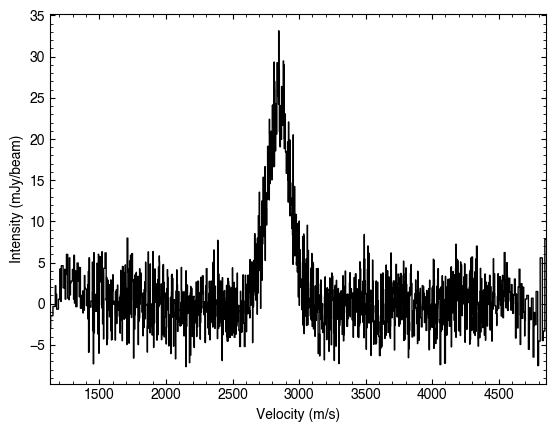

In [13]:
annulus.plot_spectrum(vrot=v_phi, resample=False)

The `resample` argument is actually quite versatile. If we provide it a float, this specifies the new channel spacing (e.g., `resample=10.0` will return the spectrum binned down to 10 m/s channels), while an integer specifies the factor that the current spacing is increased by (e.g., `resample=4` will return a spectrum with a sampling rate 4 times higher than the native data.

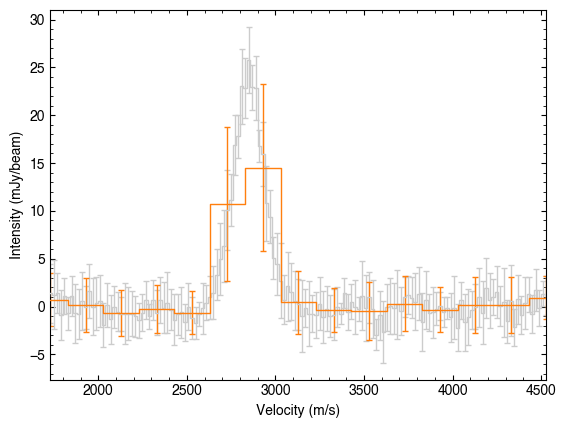

In [14]:
# resample at 20 m/s
fig = annulus.plot_spectrum(vrot=v_phi, resample=20.0,
                            plot_kwargs=dict(color='0.8'), return_fig=True)

# resample at 200 m/s
annulus.plot_spectrum(vrot=v_phi, resample=200.0,
                      ax=fig.axes[0], plot_kwargs=dict(color='C1'))


With this functionality in mind, we can look at how we can used these deprojected spectra to infer the correct velocity.

## Maximizing Signal to Noise

[Yen et al. (2018)](https://ui.adsabs.harvard.edu/abs/2018A%26A...616A.100Y/abstract) proposed that the correct velocity should maximize the signal-to-noise of the averaged spectrum. This because of two main aspects:

1) As the specrta are aligned, they will average coherently and so will result in the largest peak intensity (modulo background noise). You can see this by comparing the peak of the deprojected spectra above with and without the correct alignment. 

2) Averaging over many samples beats down the noise. For independent spectra we would expect a ${\sim} \sqrt{N}$ improvement in the noise measured in the spectrum when averaging over $N$ spectra. We have the added advantage with the velocity shifting in that some spatial correlations are decorrelated due to the shifting of the spectra (see [Yen et al., 2016,](https://ui.adsabs.harvard.edu/abs/2016ApJ...832..204Y/abstract) for a discussion about this).

This approach can get used in the `get_vlos` function using `fit_method='SNR'`.

In [15]:
print('v_phi = {:.0f} m/s'.format(annulus.get_vlos(fit_method='SNR')))

v_phi = 2605 m/s


This approach (as it is currently coded) has two issues. Firstly, it does not return an uncertainty on $v_{\rm \phi}$ as it simply uses `scipy.optimize.minimize` to minimize the negative SNR of the deprojected spectrum.

The other is that the calculation of the SNR involves several steps: measuring the 'signal' of the spectrum and measuring the 'noise' of the spectrum. The signal is calculated either by taking the integrated intensity of the deprojected spectrum (`signal='int'`, the default), or the peak intensity (`signal='max'`). As both of these quantities are very noise as a function of $v_{\rm \phi}$, the `annulus` class will fit a Gaussian profile to the deprojected spectrum to calculate these quantities.

[Yen et al. (2018)](https://ui.adsabs.harvard.edu/abs/2018A%26A...616A.100Y/abstract) also discuss this issue, and advocate for using a Gaussian weighting when calculating the SNR, such that high intensity parts of the spectrum count more to this statistic. This can be used with `signal='weighted'`.

## Minimizing Line Width

To circumvent noisiness of the SNR statistic, [Teague et al. (2018a)](https://ui.adsabs.harvard.edu/abs/2018ApJ...860L..12T/abstract) advocated for using the line width as a proxy for alignment. When the spectra are aligned correctly, the width of the averaged spectrum should be minimized. This can be used with the `fit_method='dV'` arugment.

In [16]:
print('v_phi = {:.0f} m/s'.format(annulus.get_vlos(fit_method='dV')))

v_phi = 2641 m/s


Again, this method (as it is currently coded) does not return an uncertainly. In addition, this approach requires the fitting of a Gaussian profile to the averaged spectrum which may fail for noisy spectra or poor starting conditions. One particular worry is that if the underlying profile is _not_ a Gaussian, then both these methods will fail.

## Gaussian Processes

To remove any dependence on the underlying line profile, [Teague et al. (2018c)](https://ui.adsabs.harvard.edu/abs/2018ApJ...868..113T/abstract) showed that modeling the underlying spectrum as a Gaussian Process can provide excellent results. In essence, this approach asks for what $v_{\rm \phi}$ will the noise in the spectrum be minimized (and spectrally independent). Consider how the uncertainty changes for the case of no alignment and the correct alignment.

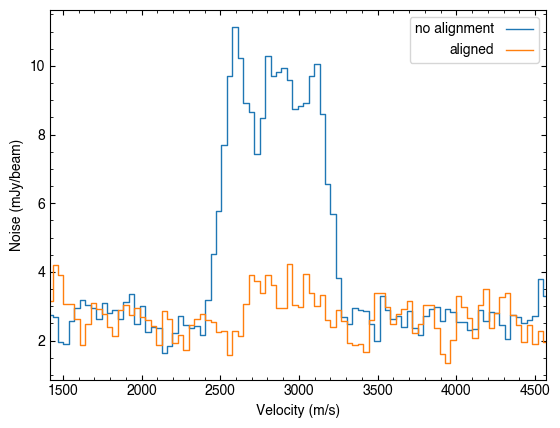

In [17]:
fig, ax = plt.subplots()

x, y, dy = annulus.deprojected_spectrum(vrot=0.0)
ax.step(x, dy * 1e3, where='mid', lw=1.0, label='no alignment')

x, y, dy = annulus.deprojected_spectrum(vrot=v_phi)
ax.step(x, dy * 1e3, where='mid', lw=1.0, label='aligned')

ax.set_ylabel('Noise (mJy/beam)')
ax.set_xlabel('Velocity (m/s)')
ax.set_xlim(x.min(), x.max())
ax.legend(markerfirst=False)

The noise rockets around the line center when the alignment is incorrect due to the misalignment of the spectra.

To implement the fitting `eddy` will use the `emcee` MCMC sampler and [celerite](https://celerite.readthedocs.io/en/stable/) for the Gaussian Processes, and can be called with the `fit_method='GP'` argument. To help with the MCMC, this function takes the commonly used `nwalkers`, `nburnin` and `nsteps` arguments that were used in earlier tutorials fitting the rotation maps. By default, `get_vlos` will return the median value of the posterior samples and half the 84th to 16th percentile as the uncertainty.

In [18]:
print('v_phi = {:.0f} +\- {:.0f} m/s'.format(*annulus.get_vlos(fit_method='GP')))

100%|██████████████████████████████████████| 1000/1000 [00:05<00:00, 169.03it/s]


v_phi = 2676 +\- 18 m/s


## Simple Harmonic Oscillator

As we saw in the [previous tutorial](https://eddy.readthedocs.io/en/latest/tutorials/tutorial_3.html) we can also fit the line centroids with a simple harmonic oscillator model.

In [19]:
v, dv = annulus.get_vlos(fit_method='SHO')
print('v_phi = {:.0f} +\- {:.0f} m/s'.format(v[0], dv[0]))

v_phi = 2607 +\- 64 m/s


## More Control

In fact, `get_vlos` is just a convenience wrapper for the underlying functions: `get_vlos_*` where `*` is the `fit_method` provide to `get_vlos`. These functions will have more functionality to aid in the fitting, such as producing plots of the walkers or posteriors for the `GP` method.